In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import timeit

In [2]:
# Set up the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
BS = 36
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


 deer  bird  ship  deer  deer   car


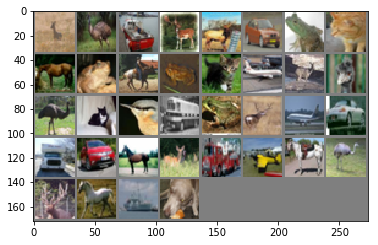

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))


In [5]:
def conv3x3(x,K):
    """3x3 convolution with padding"""
    return F.conv2d(x, K, stride=1, padding=1)

def conv3x3T(x,K):
    """3x3 convolution transpose with padding"""
    #K = torch.transpose(K,0,1)
    return F.conv_transpose2d(x, K, stride=1, padding=1)


def convDiag(x,K):
    n = K.shape
    return F.conv2d(x, K, stride=1, padding=1, groups=n[0])


def coarseImg(x,res):
    n = x.shape[2]
    while n>res:
        x = F.avg_pool2d(x, 2, 2, 0, False,False)
        n = x.shape[2]
        
    return x

dis = nn.CrossEntropyLoss()
def misfit(X,W,C):
    n = W.shape
    X = X.view(-1,n[0])
    S = torch.matmul(X,W)
    return dis(S,C), S   

def getAccuracy(S,labels):
    _, predicted = torch.max(S.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct/total

In [6]:
class ResNet(nn.Module):

    def __init__(self, h,NG):
        super().__init__()

        # network geometry
        self.NG       = NG
        # time step
        self.h        = h
        
    def forward(self,x,Kresnet):
    
        nt = len(Kresnet)        
        # time stepping
        for j in range(nt):
            
            # First case - rsent style step
            if NG[0,j] == NG[2,j]: 
                z  = conv3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                z  = F.relu(z)        
                z  = conv3x3T(z,Kresnet[j])
                x  = x - self.h*z
            # Change number of channels/resolution    
            else:
                z  = conv3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                x  = F.relu(z)
                if NG[3,j] == 1:
                    x = F.avg_pool2d(x,2)
             
             
        return x

In [7]:
# initialize net and weights
h           = 1e-1

# Network geometry
NG = np.array([3,    16,    16,    16,  16,   16,     32,    32,    32,   32,   32,
               0,    32,    32,    32,  32,    0,     64,    64,    64,   64,    0,
               16,   16,    16,    16,  16,   32,     32,    32,    32,   32,   64,
               1,     0,     0,     0,   0,    1,      0,     0,     0,    0,   1])

NG = np.reshape(NG,(4,-1))
net   = ResNet(h,NG)

nsteps = NG.shape[1]


Kresnet = []
for i in range(nsteps):  
    if NG[0,i] == NG[2,i]:
        Ki  = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]),3,3))
        stdv  = 1e-3
        Ki.data.uniform_(-stdv, stdv)
    else:
        Ki = nn.Parameter(torch.Tensor(np.asscalar(NG[2,i]), np.asscalar(NG[0,i]) ,3,3))
        stdv  = 1e-3
        Ki.data.uniform_(-stdv, stdv)
    
    Kresnet.append(Ki)
    # Move to the GPU
    Ki.data = Ki.data.to(device)

# run the network
images, labels = images.to(device), labels.to(device)
p = net(images,Kresnet)

print(p.shape)

torch.Size([36, 64, 4, 4])


In [10]:

# weights for linear classifier    
W     = nn.Parameter(torch.Tensor(p.shape[1]*p.shape[2]*p.shape[3],10))
stdv  = 1e-3
W.data.uniform_(-stdv, stdv)
    
# Move to GPU
net.to(device)
W.data = W.data.to(device)

C = torch.randint(0,10,(BS,),dtype=torch.long)
C = C.to(device)


loss,_ = misfit(p,W,C)
print(loss)    
print(np.log(10))

tensor(2.3026, grad_fn=<NllLossBackward>)
2.302585092994046


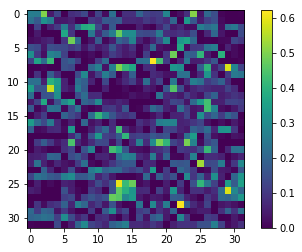

In [11]:
xnp = p.data.cpu().reshape(p.shape[0],8*4,8*4)

im = plt.imshow(xnp[1,:,:])
plt.colorbar(im)


In [12]:
import torch.optim as optim
optimizer = optim.SGD([{'params':Kresnet},{'params': W}], lr=1e-4, momentum=0)



In [13]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x    = net(inputs,Kresnet)
        loss, Si = misfit(x,W,labels)
        loss.backward()
             
        optimizer.step()

        # print statistics
        accuracy = getAccuracy(Si,labels)
        running_loss     += loss.item()
        running_accuracy += accuracy
        n_print = 200
        if i % n_print == n_print-1:    # print every 2000 mini-batches
            # compute validation accuracy
            with torch.no_grad():
                #for data in testloader:
                dataiter = iter(testloader)
                imagesV, labelsV = dataiter.next()
                imagesV, labelsV = imagesV.to(device), labelsV.to(device)
                xV = net(imagesV,Kresnet)
                lossV, SiV = misfit(xV,W,labelsV)
                accuracyV  = getAccuracy(SiV,labelsV)

            
            print('[%d, %5d]  %.3f  %.3f  %.3f' %
                  (epoch + 1, i + 1, running_loss / n_print, running_accuracy/n_print, accuracyV))
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

[1,   200]  2.294  0.177  0.260
[1,   400]  2.266  0.212  0.240
[1,   600]  2.237  0.216  0.250
[1,   800]  2.212  0.235  0.310
[1,  1000]  2.173  0.254  0.310
[1,  1200]  2.131  0.271  0.340
[2,   200]  2.051  0.299  0.410
[2,   400]  2.007  0.313  0.450
[2,   600]  1.966  0.334  0.450
[2,   800]  1.947  0.330  0.480
[2,  1000]  1.925  0.327  0.480
[2,  1200]  1.903  0.339  0.470
[3,   200]  1.858  0.364  0.480
[3,   400]  1.820  0.377  0.510
[3,   600]  1.813  0.375  0.510
[3,   800]  1.805  0.373  0.450
[3,  1000]  1.770  0.390  0.520
[3,  1200]  1.757  0.402  0.510
[4,   200]  1.706  0.415  0.490
[4,   400]  1.704  0.424  0.530
[4,   600]  1.701  0.412  0.510
[4,   800]  1.670  0.423  0.500
[4,  1000]  1.667  0.418  0.530
[4,  1200]  1.649  0.431  0.490
[5,   200]  1.620  0.448  0.510
[5,   400]  1.606  0.448  0.550
[5,   600]  1.597  0.450  0.490
[5,   800]  1.592  0.450  0.510
[5,  1000]  1.584  0.456  0.520
[5,  1200]  1.559  0.456  0.510
[6,   200]  1.539  0.464  0.510
[6,   40

Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

In [28]:
t = Kresnet[0]
for i in range(len(Kresnet)):
    t = Kresnet[i]
    print(torch.min(t),torch.max(t))

tensor(1.00000e-02 *
       -2.6588, device='cuda:0') tensor(1.00000e-02 *
       3.0053, device='cuda:0')
tensor(1.00000e-03 *
       -2.1094, device='cuda:0') tensor(1.00000e-03 *
       2.1130, device='cuda:0')
tensor(1.00000e-03 *
       -2.0151, device='cuda:0') tensor(1.00000e-03 *
       1.9631, device='cuda:0')
tensor(1.00000e-03 *
       -2.1032, device='cuda:0') tensor(1.00000e-03 *
       2.0331, device='cuda:0')
tensor(1.00000e-03 *
       -7.8443, device='cuda:0') tensor(1.00000e-03 *
       7.9333, device='cuda:0')
tensor(1.00000e-03 *
       -1.6756, device='cuda:0') tensor(1.00000e-03 *
       1.7639, device='cuda:0')
tensor(1.00000e-03 *
       -1.9126, device='cuda:0') tensor(1.00000e-03 *
       1.7319, device='cuda:0')
tensor(1.00000e-03 *
       -1.7716, device='cuda:0') tensor(1.00000e-03 *
       1.7622, device='cuda:0')
tensor(1.00000e-03 *
       -3.0799, device='cuda:0') tensor(1.00000e-03 *
       3.7272, device='cuda:0')
